In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from keras.models import Model, Sequential, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Conv2D, Dropout, Dense, Flatten, MaxPooling2D, GlobalMaxPooling2D, GlobalAveragePooling2D, Input, Concatenate
from keras.applications import mobilenet_v2, nasnet
from keras.losses import binary_crossentropy
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import time
from PIL import Image
import pandas as pd
import model_evaluation_utils as meu
import cv2
from google.cloud import storage
import os
from collections import defaultdict

Using TensorFlow backend.


In [2]:
storage_client = storage.Client()

bucket_name = "citric-inkwell-268501"

In [3]:
def showNumpyImage(image):
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), interpolation='nearest')
    plt.show()

In [4]:
def upload_blob(bucket_name, source_file_name, destination_blob_name):
    """Uploads a file to the bucket."""
    # bucket_name = "your-bucket-name"
    # source_file_name = "local/path/to/file"
    # destination_blob_name = "storage-object-name"

    storage_client = storage.Client()
    bucket = storage_client.bucket(bucket_name)
    blob = bucket.blob(destination_blob_name)

    blob.upload_from_filename(source_file_name)

    print(
        "File {} uploaded to {}.".format(
            source_file_name, destination_blob_name
        )
    )

In [5]:
def download_blob(bucket_name, source_blob_name, destination_file_name):
    """Downloads a blob from the bucket."""
    # bucket_name = "your-bucket-name"
    # source_blob_name = "storage-object-name"
    # destination_file_name = "local/path/to/file"

    storage_client = storage.Client()

    bucket = storage_client.bucket(bucket_name)
    blob = bucket.blob(source_blob_name)
    blob.download_to_filename(destination_file_name)

    print(
        "Blob {} downloaded to {}.".format(
            source_blob_name, destination_file_name
        )
    )

In [6]:
# Load Data
# data = np.load("training_data.npy", allow_pickle = True)

# # Split into labels and images then test and train
# x = np.array([i[0] for i in data])
# y = np.array([i[1] for i in data])
# train_x, test_x, train_y, test_y = train_test_split(x, y, test_size = 0.2, random_state = 42)

# # Scale images
# train_x_scaled = train_x.astype('float32')
# test_x_scaled = test_x.astype('float32')
# train_x_scaled /= 255
# test_x_scaled /= 255

# Check for existance of local model_cache and create if it does not exist
if os.path.isdir('./model_cache/VGG16_cache'):
    print("Model Cache Exists")
else:
    os.makedirs("./model_cache/VGG16_cache")
    print("Created Model Cache")

bucket_files = ['training_sets/full_augmentation/full_augmentation_train_x_aug.npy', 'training_sets/full_augmentation/full_augmentation_train_y_aug.npy']

training_sets = defaultdict(list)
for set in bucket_files:
    if "training_sets" in set:
        training_sets[set.split("/")[1]].append(set.replace("/","-"))
        if os.path.exists(os.path.join("./model_cache/VGG16_cache", str(set.replace("/","-")))):
            print("{} already downloaded".format(str(set.split("/")[1])))
        else:
            print("{}  downloading".format(str(set.split("/")[1])))
            download_blob(bucket_name, set, os.path.join("./model_cache/VGG16_cache", str(set.replace("/","-"))))
            print("{}  done downloading".format(str(set.split("/")[1])))
    else:
        continue


Model Cache Exists
full_augmentation already downloaded
full_augmentation already downloaded


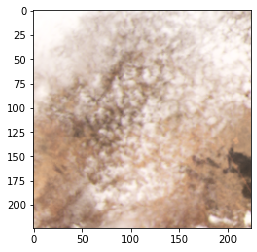

In [4]:
showNumpyImage(train_x[2645])

In [32]:
# Configure base model
input_shape = (224, 224, 3)
model_mobilenet = mobilenet_v2.MobileNetV2(include_top = False, weights = 'imagenet', input_shape = input_shape)
output = model_mobilenet.layers[-1].output
output = keras.layers.Flatten()(output)
mobile_model = Model(model_mobilenet.input, output)

# Set blocks 15 and 16 to be fine tuneable
mobile_model.trainable = True
set_trainable = False
for layer in mobile_model.layers:
    if layer.name in ['block_15_expand']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

layers = [(layer, layer.name, layer.trainable) for layer in mobile_model.layers]
pd.DataFrame(layers, columns = ['Layer Type', 'Layer Name', 'Layer Trainable'])

,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at...,input_8,False
1,<keras.layers.convolutional.ZeroPadding2D obje...,Conv1_pad,False
2,<keras.layers.convolutional.Conv2D object at 0...,Conv1,False
3,<keras.layers.normalization.BatchNormalization...,bn_Conv1,False
4,<keras.layers.advanced_activations.ReLU object...,Conv1_relu,False
...,...,...,...
151,<keras.layers.normalization.BatchNormalization...,block_16_project_BN,True
152,<keras.layers.convolutional.Conv2D object at 0...,Conv_1,True
153,<keras.layers.normalization.BatchNormalization...,Conv_1_bn,True
154,<keras.layers.advanced_activations.ReLU object...,out_relu,True


In [45]:
pd.DataFrame(layers, columns = ['Layer Type', 'Layer Name', 'Layer Trainable']).tail(10)

,Layer Type,Layer Name,Layer Trainable
146,<keras.layers.advanced_activations.ReLU object...,block_16_expand_relu,False
147,<keras.layers.convolutional.DepthwiseConv2D ob...,block_16_depthwise,False
148,<keras.layers.normalization.BatchNormalization...,block_16_depthwise_BN,False
149,<keras.layers.advanced_activations.ReLU object...,block_16_depthwise_relu,False
150,<keras.layers.convolutional.Conv2D object at 0...,block_16_project,False
151,<keras.layers.normalization.BatchNormalization...,block_16_project_BN,False
152,<keras.layers.convolutional.Conv2D object at 0...,Conv_1,False
153,<keras.layers.normalization.BatchNormalization...,Conv_1_bn,False
154,<keras.layers.advanced_activations.ReLU object...,out_relu,False
155,<keras.layers.core.Flatten object at 0x7f762e1...,flatten_3,False


In [35]:
# Run model for unaugmented data
base_model = mobilenet_v2.MobileNetV2(include_top=False, input_shape=(224, 224, 3), weights='imagenet')

# Set blocks 15 and 16 to be fine tuneable
base_model.trainable = True
set_trainable = False
for layer in base_model.layers:
    if layer.name in ['block_4_expand']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

inputs = Input((224, 224, 3))
x = base_model(inputs)
out1 = GlobalMaxPooling2D()(x)
out2 = GlobalAveragePooling2D()(x)
out3 = Flatten()(x)
out = Concatenate(axis=-1)([out1, out2, out3])
out = Dropout(0.5)(out)
out = Dense(1, activation="sigmoid", name="3_")(out)
model = Model(inputs, out)
model.compile(optimizer=Adam(0.0001), loss=binary_crossentropy, metrics=['acc'])

model.summary()

# Save base model weights so the model can be reset after each training
baseWeights = model.get_weights()
# Loop and train using each training set
### NOTE: You can still leave this alone if you've only downloaded the fully augmented set.
for training_set in training_sets:
    print("     Starting training for set {}".format(str(training_set)))
    model.set_weights(baseWeights) # Resets model
    train_x = np.load(os.path.join("./model_cache/VGG16_cache", training_sets[training_set][0]))
    train_y = np.load(os.path.join("./model_cache/VGG16_cache", training_sets[training_set][1]))
    early_stopping_monitor = EarlyStopping(patience=10)
    history = model.fit(train_x, train_y, batch_size=32, epochs=10, verbose=1, validation_split = 0.2, shuffle=True, callbacks=[early_stopping_monitor])        
  

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
mobilenetv2_1.00_224 (Model)    (None, 7, 7, 1280)   2257984     input_12[0][0]                   
__________________________________________________________________________________________________
global_max_pooling2d_4 (GlobalM (None, 1280)         0           mobilenetv2_1.00_224[1][0]       
__________________________________________________________________________________________________
global_average_pooling2d_4 (Glo (None, 1280)         0           mobilenetv2_1.00_224[1][0]       
____________________________________________________________________________________________

In [36]:
# download test set
bucket_files = ['test_set/test_x.npy', 'test_set/test_y.npy']

testing_sets = defaultdict(list)
for set in bucket_files:
    if "test_set" in set:
        testing_sets[set.split("/")[1]].append(set.replace("/","-"))
        if os.path.exists(os.path.join("./model_cache/VGG16_cache", str(set.replace("/","-")))):
            print("{} already downloaded".format(str(set.split("/")[1])))
        else:
            print("{}  downloading".format(str(set.split("/")[1])))
            download_blob(bucket_name, set, os.path.join("./model_cache/VGG16_cache", str(set.replace("/","-"))))
            print("{}  done downloading".format(str(set.split("/")[1])))
    else:
        continue

test_x.npy already downloaded
test_y.npy already downloaded


In [39]:
test_x = np.load(os.path.join("./model_cache/VGG16_cache", 'test_set-test_x.npy'))
test_y = np.load(os.path.join("./model_cache/VGG16_cache", 'test_set-test_y.npy'))

# Make predictions with model and convert predictions into binary
test_predictions = model.predict(test_x)
test_predictions_labelled = [0 if x<0.5 else 1 for x in test_predictions]

In [40]:
# Display performance metrics
meu.display_model_performance_metrics(true_labels=test_y, predicted_labels=test_predictions_labelled)

Model Performance metrics:
------------------------------
Accuracy: 0.946
Precision: 0.9489
Recall: 0.946
F1 Score: 0.9218

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           1       1.00      0.04      0.08        49
           0       0.95      1.00      0.97       821

    accuracy                           0.95       870
   macro avg       0.97      0.52      0.53       870
weighted avg       0.95      0.95      0.92       870


Prediction Confusion Matrix:
------------------------------
[[  2  47]
 [  0 821]]


## NASNetMobile

In [31]:
# Configure base model
input_shape = (224, 224, 3)
base_model = nasnet.NASNetMobile(include_top = False, weights = 'imagenet', input_shape = input_shape)
# output = model_mobilenet.layers[-1].output
# output = keras.layers.Flatten()(output)
# mobile_model = Model(model_mobilenet.input, output)

# Set blocks 15 and 16 to be fine tuneable
base_model.trainable = True
set_trainable = False
for layer in base_model.layers:
    if layer.name in ['block_15_expand']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

layers = [(layer, layer.name, layer.trainable) for layer in base_model.layers]
pd.DataFrame(layers, columns = ['Layer Type', 'Layer Name', 'Layer Trainable']).tail(50)

,Layer Type,Layer Name,Layer Trainable
719,<keras.layers.merge.Add object at 0x7fa77a8b7f90>,normal_add_3_11,False
720,<keras.layers.merge.Add object at 0x7fa77a874b90>,normal_add_4_11,False
721,<keras.layers.merge.Add object at 0x7fa77a874610>,normal_add_5_11,False
722,<keras.layers.merge.Concatenate object at 0x7f...,normal_concat_11,False
723,<keras.layers.core.Activation object at 0x7fa7...,activation_928,False
724,<keras.layers.core.Activation object at 0x7fa7...,activation_929,False
725,<keras.layers.convolutional.Conv2D object at 0...,adjust_conv_projection_12,False
726,<keras.layers.convolutional.Conv2D object at 0...,normal_conv_1_12,False
727,<keras.layers.normalization.BatchNormalization...,adjust_bn_12,False
728,<keras.layers.normalization.BatchNormalization...,normal_bn_1_12,False


In [12]:
base_model = nasnet.NASNetMobile(include_top=False, input_shape=(224, 224, 3), weights='imagenet')

# Set blocks 15 and 16 to be fine tuneable
base_model.trainable = True
set_trainable = False
for layer in base_model.layers:
    if layer.name in ['block_15_expand']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

inputs = Input((224, 224, 3))
x = base_model(inputs)
out1 = GlobalMaxPooling2D()(x)
out2 = GlobalAveragePooling2D()(x)
out3 = Flatten()(x)
out = Concatenate(axis=-1)([out1, out2, out3])
out = Dropout(0.5)(out)
out = Dense(1, activation="sigmoid", name="3_")(out)
model = Model(inputs, out)
model.compile(optimizer=Adam(0.0001), loss=binary_crossentropy, metrics=['acc'])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
NASNet (Model)                  (None, 7, 7, 1056)   4269716     input_4[0][0]                    
__________________________________________________________________________________________________
global_max_pooling2d_2 (GlobalM (None, 1056)         0           NASNet[1][0]                     
__________________________________________________________________________________________________
global_average_pooling2d_2 (Glo (None, 1056)         0           NASNet[1][0]                     
____________________________________________________________________________________________

In [13]:
# Save base model weights so the model can be reset after each training
baseWeights = model.get_weights()
# Loop and train using each training set
### NOTE: You can still leave this alone if you've only downloaded the fully augmented set.
for training_set in training_sets:
    print("     Starting training for set {}".format(str(training_set)))
    model.set_weights(baseWeights) # Resets model
    train_x = np.load(os.path.join("./model_cache/VGG16_cache", training_sets[training_set][0]))
    train_y = np.load(os.path.join("./model_cache/VGG16_cache", training_sets[training_set][1]))
    early_stopping_monitor = EarlyStopping(patience=10)
    history = model.fit(train_x, train_y, batch_size=32, epochs=10, verbose=1, validation_split = 0.2, shuffle=True, callbacks=[early_stopping_monitor])        


     Starting training for set full_augmentation
Train on 4656 samples, validate on 1164 samples
Epoch 1/10
4656/4656 [==============================] - 46s 10ms/step - loss: 0.3639 - acc: 0.8628 - val_loss: 1.0255 - val_acc: 0.6108
Epoch 2/10
4656/4656 [==============================] - 29s 6ms/step - loss: 0.2122 - acc: 0.9265 - val_loss: 0.9922 - val_acc: 0.6572
Epoch 3/10
4656/4656 [==============================] - 29s 6ms/step - loss: 0.1526 - acc: 0.9450 - val_loss: 0.8129 - val_acc: 0.7328
Epoch 4/10
4656/4656 [==============================] - 29s 6ms/step - loss: 0.1169 - acc: 0.9592 - val_loss: 0.9034 - val_acc: 0.7182
Epoch 5/10
4656/4656 [==============================] - 29s 6ms/step - loss: 0.1245 - acc: 0.9570 - val_loss: 0.5644 - val_acc: 0.8282
Epoch 6/10
4656/4656 [==============================] - 29s 6ms/step - loss: 0.1037 - acc: 0.9622 - val_loss: 0.5439 - val_acc: 0.8497
Epoch 7/10
4656/4656 [==============================] - 29s 6ms/step - loss: 0.0912 - acc: 0

In [14]:
# download test set
bucket_files = ['test_set/test_x.npy', 'test_set/test_y.npy']

testing_sets = defaultdict(list)
for set in bucket_files:
    if "test_set" in set:
        testing_sets[set.split("/")[1]].append(set.replace("/","-"))
        if os.path.exists(os.path.join("./model_cache/VGG16_cache", str(set.replace("/","-")))):
            print("{} already downloaded".format(str(set.split("/")[1])))
        else:
            print("{}  downloading".format(str(set.split("/")[1])))
            download_blob(bucket_name, set, os.path.join("./model_cache/VGG16_cache", str(set.replace("/","-"))))
            print("{}  done downloading".format(str(set.split("/")[1])))
    else:
        continue

test_x.npy already downloaded
test_y.npy already downloaded


In [27]:
test_x = np.load(os.path.join("./model_cache/VGG16_cache", 'test_set-test_x.npy'))
test_y = np.load(os.path.join("./model_cache/VGG16_cache", 'test_set-test_y.npy'))

# Make predictions with model and convert predictions into binary
test_predictions = model.predict(test_x)
test_predictions_labelled = [0 if x<0.1 else 1 for x in test_predictions]

In [28]:
# Display performance metrics
meu.display_model_performance_metrics(true_labels=test_y, predicted_labels=test_predictions_labelled)

Model Performance metrics:
------------------------------
Accuracy: 0.9287
Precision: 0.9367
Recall: 0.9287
F1 Score: 0.9324

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           1       0.39      0.49      0.44        49
           0       0.97      0.95      0.96       821

    accuracy                           0.93       870
   macro avg       0.68      0.72      0.70       870
weighted avg       0.94      0.93      0.93       870


Prediction Confusion Matrix:
------------------------------
[[ 24  25]
 [ 37 784]]
